<a href="https://colab.research.google.com/github/wilkieolin/VSA-notebooks/blob/main/VSA_Introduction_2_Bundling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recap
In the last tutorial, we introduced some basic concepts of vector-symbolic architectures (VSAs): the use of a vector of values on a particular domain to represent a symbol, the measurement of similarity between vector-symbols, and the fact that as these symbols grow longer, similarity between random symbols approaches zero. 

In this tutorial, we'll go farther by introducing a simple operation, called 'bundling' (alternately, 'superposition' or 'addition') which creates a single symbol which represents a set of others. 

# Sets

Let's assume we have a large set of symbols, a subset of which we wish to represent as a collection - for instance, out of a large list of concepts we want to group 'dog', 'cat,' and 'tiger' together as 'animals.' In standard computer science, we can do this via lists:

In [1]:
#list of concepts
concepts = ["desk", "chair", "mug", "dog", "cat", "tiger", "airplane", "car"]
#subgroup of animals
animals = concepts[3:6]

print("Animals: ", *animals)

Animals:  dog cat tiger


Inside the computer, our "animals" subgroup can be represented by list of 3 pointers back to the original objects ("dog", "cat", and "tiger"). This list grows in size with additional element we want to add to it. 

Now, if we want to create other collections, we can do so with new lists: 

In [2]:
#subgroup of house pets
pets = concepts[3:5]
print("Pets: ", *pets)

#subgroup of furniture
furniture = concepts[0:2]
print("Furniture: ", *furniture)

Pets:  dog cat
Furniture:  desk chair


Using this representation of a set, if we want to compare the similarity between any two collections, we have to traverse through each list, retrieve the items from each, and compare them to find features like the intersection between the lists:


In [3]:
for animal in animals: 
  if animal in pets:
    print(animal, "is an animal and a house pet.")

dog is an animal and a house pet.
cat is an animal and a house pet.


VSAs allow us to change our approach in a major way. Each original concept is instead instantiated as a random vector-symbol. 

In [4]:
#standard imports
import jax.numpy as jnp
from jax import random

import matplotlib.pyplot as plt

#create a helper function to generate random symbols
def generate_symbols(key, number: int, dimensionality: int):
    return random.uniform(key, minval=-1.0, maxval=1.0, shape=(number, dimensionality))

#similarity of FHRR vectors is defined by the average cosine of the difference between each angle in the two symbols being compared.
def similarity(a,b):
    assert a.shape[-1] == b.shape[-1], "VSA Dimension must match: " + str(a.shape) + " " + str(b.shape)
    #multiply values by pi to move from (-1, 1) to (-π, π)
    pi = jnp.pi
    a = jnp.multiply(a, pi)
    b = jnp.multiply(b, pi)
    #calculate the mean cosine similarity between the vectors
    similarity = jnp.mean(jnp.cos(a - b), axis=1)
    return similarity

#create the key used to generate random values with JAX
key = random.PRNGKey(42)

#set the dimensionality of the VSA
dimensionality = 1000

In [5]:
key, subkey = random.split(key)
vsa_concepts = generate_symbols(subkey, len(concepts), dimensionality)

desk = vsa_concepts[0:1,:]
chair = vsa_concepts[1:2,:]
mug = vsa_concepts[2:3,:]
dog = vsa_concepts[3:4,:]
cat = vsa_concepts[4:5,:]
tiger = vsa_concepts[5:6,:]
airplane = vsa_concepts[6:7,:]
car = vsa_concepts[7:8,:]

Each concept now has a corresponding symbol - for instance, "desk" is represented by the first row in the ```vsa_concepts``` matrix. Now, let's define the bundling operation.

# Bundling

In [6]:
#Bundling operation for FHRR
def bundle(*symbols):
    symbols = jnp.stack(symbols, axis=0)
    #convert each angle to a complex number
    pi = jnp.pi
    j = jnp.array([0+1j])

    #sum the complex numbers to find the bundled vector
    cmpx = jnp.exp(pi * j * symbols)
    bundle = jnp.sum(cmpx, axis=0)
    #convert the complex sum back to an angle
    bundle = jnp.angle(bundle) / pi
    bundle = jnp.reshape(bundle, (1, -1))

    return bundle

In the FHRR VSA, bundling is accomplished by taking each of the input symbols and converting every angle to an equivalent complex number via [Euler's formula](https://en.wikipedia.org/wiki/Euler%27s_formula). These vectors of complex numbers are then summed element-wise, and the angle of the resulting sum is taken to form the new vector. Essentially, this operation finds an 'average value' for each set of elements in the input symbols. 

The central purpose of this bundling operation is to create a single new symbol which is highly similar to its set of inputs. At the minimum, this new symbol should be more similar to the inputs than to random symbols. As the number of inputs increases, this becomes more challenging to accomplish.

Let's start with a simple demonstration of using bundling to represent a set of objects, just as we previously accomplished with lists:

In [7]:
animals = bundle(dog, cat, tiger)

We've now created a single symbol to represent our collection of "animals." As we can see by calculating its similarity to all of the concepts we've defined, the only symbols highly similar to it are "dog," "cat," and "tiger." This is exactly what we expect, since those were the symbols bundled together to create the 'animals' symbol. 

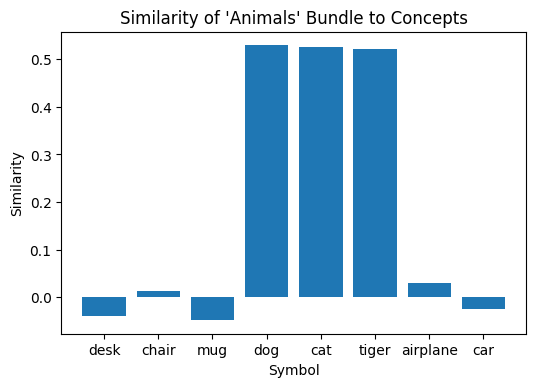

In [8]:
#compare "animals" symbol to all concepts
plt.figure(dpi=100)
plt.bar(concepts, similarity(animals, vsa_concepts))
plt.xlabel("Symbol")
plt.ylabel("Similarity")
plt.title("Similarity of 'Animals' Bundle to Concepts");

Let's create some other bundled vectors to represent the lists we had previously: household pets (dog, cat) and furniture (desk, chair). 

In [9]:
pets = bundle(dog, cat) 
furniture = bundle(desk, chair) 

Once again, the new bundled vectors formed for these sets are only similar to the inputs used to create them:

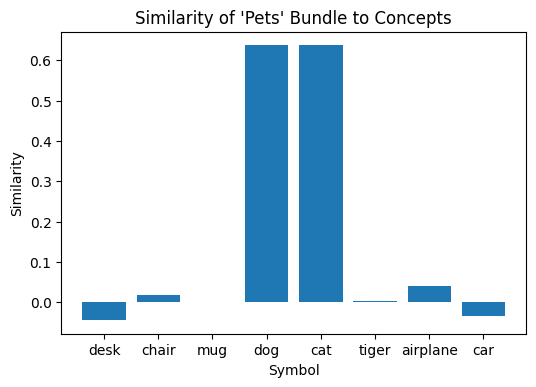

In [10]:
#compare "pets" symbol to all concepts
plt.figure(dpi=100)
plt.bar(concepts, similarity(pets, vsa_concepts))
plt.xlabel("Symbol")
plt.ylabel("Similarity")
plt.title("Similarity of 'Pets' Bundle to Concepts");

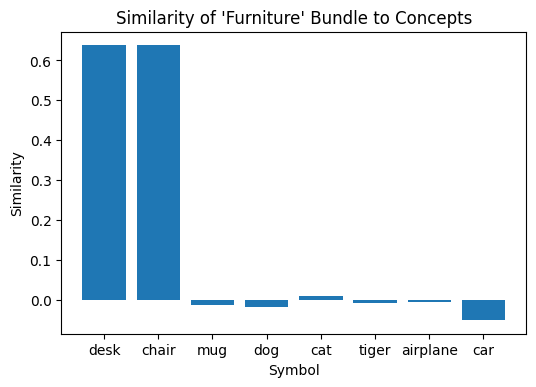

In [11]:
#compare "furniture" symbol to all concepts
plt.figure(dpi=100)
plt.bar(concepts, similarity(furniture, vsa_concepts))
plt.xlabel("Symbol")
plt.ylabel("Similarity")
plt.title("Similarity of 'Furniture' Bundle to Concepts");

One of the advantages of using a symbol created through bundling to represent a set is the fact that these representations can be *directly compared.* We don't need to traverse through two lists and compare items one by one: each set is represented by a single vector-symbol, a pair of which can compared via similarity. 

For instance, let's compare the similarity of the 'pets' and 'animals' symbols:

In [12]:
#compare "pets" to "animals"
similarity_0 = similarity(pets, animals).item()
print(similarity_0)

0.6818754076957703


These sets are highly similar, with 66% of items in 'animals' also belonging to 'pets.' This is reflected by the high similarity score between the two symbols constructed to represent these sets. Now, let's compare the 'animals' and 'furniture' symbols:

In [13]:
#compare "animals" to "furniture"
similarity(animals, furniture).item()

-0.00309000420384109

Sharing no original inputs, the symbols for these sets have a similarity score of approximately zero. 

Because of the way in which these sets are represented - via vector-symbols - we can make these powerful comparisons between them in a single step, rather than iterating through lists and dereferencing pointers to make a comparison. This is one of the key advantages of VSAs: the ability to directly and efficiently compare symbols representing complex structures. 

However, as you may have noticed, one of the key disadvantages of VSAs is that they are *noisy.* None of the similarity values we calculate are *exactly* zero. Bundling of vectors runs into the limit that as the number of inputs increases, the similarity of the output vector to each input decreases (this is subject to some assumptions, such as each input symbol is random; if input symbols are already similar, it's easier to create a bundle to be similar to each of them). 

Let's next take a look at how bundling performs as the number of random input symbols scales.

# Number of Inputs

A symbol created by bundling a set of inputs has to compromise between accurately representing each of its inputs. You can imagine that for 100 random input symbols, it is difficult to create a new symbol that is highly similar to each of these inputs. 

Let's examine how difficult it is to re-discover which components were used to create a bundle as the number of components increases. We'll do this by comparing trends in two quantities: the similarity between a set of symbols and their bundle, and the similarity between that bundle and a different set of random symbols. The first quantity represents a 'signal,' or how well the bundle can represent each of its inputs, and the second provides a baseline or 'noise' which informs us how similar the bundle is to symbols which were not involved in its computation.

In [14]:
#Bundling operation for FHRR matrices
def bundle_matrix(symbols):
    pi = jnp.pi
    j = jnp.array([0+1j])

    #sum the complex numbers to find the bundled vector
    cmpx = jnp.exp(pi * j * symbols)
    bundle = jnp.sum(cmpx, axis=0)
    #convert the complex sum back to an angle
    bundle = jnp.angle(bundle) / pi
    bundle = jnp.reshape(bundle, (1, -1))

    return bundle

In [15]:
#calculate the 'signal' - similarity between a set of input symbols and their bundle
def inner_similarity(input_symbols):
    b = bundle_matrix(input_symbols)
    s = similarity(b, input_symbols)

    return s

In [16]:
#calculate the 'noise' - similarity between a bundled symbol and a set of random symbols
def outer_similarity(input_symbols, random_symbols):
    b = bundle_matrix(input_symbols)
    s = similarity(b, random_symbols)

    return s

In [17]:
"""
Dispatch a trial to calculate the similarity between a bundle, its components, and 
random symbols. Takes a PRNG key, number of symbols to be bundled, number of trials
to calculate over, number of random symbols to compare to, and dimensionality of
the vector-symbol.
"""
def bundle_trial(key, 
                 n_bundle: int, 
                 n_trials: int = 5, 
                 n_random: int = 1000, 
                 dimensionality: int = 1000):
  
    #generate PRNG subkeys
    subkeys = random.split(key, 2 * n_trials)

    #dispatch symbol generation
    generate_bundle = lambda x: generate_symbols(x, n_bundle, dimensionality)
    generate_random = lambda x: generate_symbols(x, n_random, dimensionality)

    bundle_symbols = list(map(generate_bundle, subkeys[0:n_trials]))
    random_symbols = list(map(generate_random, subkeys[n_trials:]))

    #calculate the similarity between a bundled symbol and its inputs for n_trials trials
    inner_sim = jnp.array(list(map(inner_similarity, bundle_symbols)))
    #calculate the similarity between a bundled symbol and random symbols for n_trials trials
    outer_sim = jnp.array(list(map(outer_similarity, bundle_symbols, random_symbols)))

    #calculate average statistics over each trial
    intra_mean = jnp.mean(inner_sim)
    intra_std = jnp.std(inner_sim)

    inter_mean = jnp.mean(outer_sim)
    inter_std = jnp.std(outer_sim)

    return intra_mean, inter_mean, intra_std, inter_std

We'll run this experiment over a range of 2 symbols in a bundle to 101 symbols in a bundle, with 5 trials at each step. The default dimensionality is the same as we've been using (1000). This experiment should take around 60 seconds to run. 

In [18]:
#define the range of symbols we are bundling
n_bundle = jnp.arange(start = 2, stop = 101, step = 2, dtype = int)
#generate the PRNG keys
n_steps = len(n_bundle)
keys = random.split(key, n_steps+1)
key = keys[0]
subkeys = keys[1:]

fn = lambda x, y: bundle_trial(x, y, n_trials = 5)
#dispatch the calculation over number of symbols to be bundled
result = jnp.array(list(map(fn, subkeys, n_bundle)))

#separate the means & standard deviations from the result
bundle_means = result[:, 0:2]
bundle_stds = result[:, 2:4]

In [19]:
"""
Plotting function to visualize the experiment's results. 
Sigma controls the height of the vertical fill, a higher value shows means we want
to be more conservative in the risk of mistaking a bundled vector for a random one.
"""

def plot_results(n_bundle, bundle_means, bundle_stds, sigma: float = 0.0):
    plt.figure(dpi=100)

    #plot the signal's mean & fill between (sigma) standard deviations
    plt.plot(n_bundle, bundle_means[:, 0], label="Bundle-Input Similarity (Signal)")
    plt.fill_between(n_bundle, 
                    bundle_means[:, 0] - sigma * bundle_stds[:, 0],
                    bundle_means[:, 0] + sigma * bundle_stds[:, 0], alpha=0.3)

    #plot the noise's mean & fill between (sigma) standard deviations
    plt.plot(n_bundle, bundle_means[:, 1], label="Bundle-Random Similarity (Noise)")
    plt.fill_between(n_bundle, 
                    bundle_means[:, 1] - sigma * bundle_stds[:, 1],
                    bundle_means[:, 1] + sigma * bundle_stds[:, 1], alpha=0.3)

    plt.legend()
    plt.xlabel("Number of Bundled Symbols")
    plt.ylabel("Similarity")
    plt.title("Similarity Between Bundled Vector, Inputs, and Random Vectors")

Now let's look at the results from that experiment. They show the trend that we expect to see: As more symbols are bundled together, the risk that we can't correctly use similarity to identify which symbols were used to construct the bundle increases. 

Here, we plot a distribution of similarities by identifying its mean value (blue / orange lines) and filling in 3 standard deviations above and below this line. Where these two arcs for signal and noise begin to overlap (approximately 45 symbols bundled), we begin to lose the power to recover the input symbols confidently. 

From the previous notebook, we know that vector-symbol dimensionality has an effect on the distribution of similarities between random symbols. Given this relationship, we can predict how this also affects the ability of bundling to represent more symbols as dimensionality increases. You can check your prediction by modifying the code above and re-running the experiment and plots. 


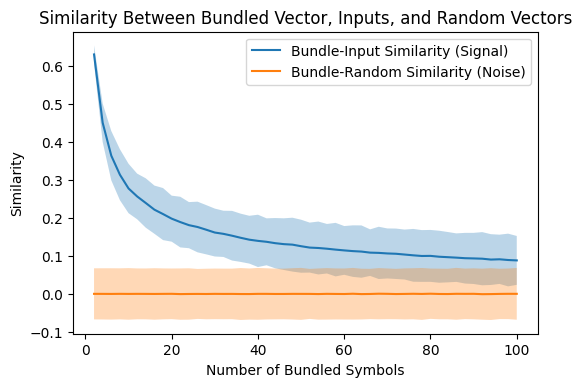

In [20]:
plot_results(n_bundle, bundle_means, bundle_stds, sigma = 3.0)

# Conclusion

In this notebook, we've introduced the concept of 'bundling' in vector-symbolic architectures. Essentially, this function constructs a single new symbol from a set of inputs, trying to maintain similarity between these inputs and the new output symbol. This allows us to represent a set of symbols via a single, other symbol. These sets can then be easily stored and compared, and their components re-identified by checking similarity to a known set of possible inputs. 

However, we've shown that the greater the number of inputs used to construct a bundle, the harder it is to accurately represent each of those inputs. Even so, this estimate was a worst-case bound, where each input symbol was random. We may wish instead to bundle a set of similar inputs together. 

For instance, in one example we bundled 'dog' and 'cat' together into 'pets.' In this example, 'dog' and 'cat' were random vectors with approximately 0 similarity:

In [21]:
similarity(dog, cat).item()

0.006434498354792595

Yet, we know that dogs and cats share many features: they are both 4 legged, domesticated mammals. As such, it would likely make sense if the symbols for 'cat' and 'dog' shared similarity to begin with. So, how should they be constructed?

This is one of the challenges of VSAs: determining how input data, including prior knowledge, is mapped into symbols to begin with, as well as determining what are fundamental, atomic symbols, and what concepts should be constructed from these atoms. Fortunately, neural networks are beginning to provide one potential solution to this challenge which we'll address in a later tutorial.  But before introducing how neural networks can work with vector-symbols, we'll address another fundamental operation in VSAs: *binding.* 

Sets alone are insufficient to describe complex relationships. If I want to create a symbol to represent the concept of "the cat ate the fish," it's insufficient to simply bundle together a set of concepts such as "cat, eating, fish." Bundles do not contain order or precedence, so when decoding the bundle it would be just as valid to interpret it as "fish, eating, cat," which is not the concept we wish to convey.

Binding provides a way of attaching two or more concepts together in a way preserves information from its components, but which *does not* preserve similarity to them. We'll see in the next tutorial how this additional function allows us to construct advanced data structures within a symbol, including graphs. 